In [1]:
#%pip uninstall -y numpy

In [2]:
#%pip install \
#  --upgrade --force-reinstall \
#  "numpy<2.0" \
#  pyarrow \
#  scikit-learn \
#  matplotlib \
#  seaborn

# Project 6 and 7

For my final project, encompassing project 6 and 7, I will work with the [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv).

To cover Project 6, I used Blob Storage on Azure to store the required data files and created a compute instance on Azure Machine Learning Studio in order to run code. Lastly, Storage Account that contains the blob is only available via a private endpoint, to ensure that only authorized users have access.

To cover Project 7, the dataset is large (1M+ entries). Furthermore, I will use Spark to run ALS and I will also use the recommender package that is available on Azure ML to train a model.

The goal will be to create recommendation models that can predict user ratings for items with a high accuracy, measured by metrics such as RMSE, MSE, and MAE.



In [3]:
import numpy as np
#print(np.__version__)    

import pyarrow       
import sklearn        
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd, io

Below I use Azure features to connect to the blob via a private endpoint and pull the required files from blob storage.

In [5]:
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

In [6]:
# authenticate via managed identity over the VNet/private endpoint
cred = DefaultAzureCredential()
svc = BlobServiceClient(
    account_url="https://data612storage.blob.core.windows.net/",
    credential=cred
)


In [7]:
blob = svc.get_blob_client("finalproject", "Ratings.csv")
data = blob.download_blob().readall()

# load into pandas
df = pd.read_csv(io.BytesIO(data))
df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Exploratory Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


The dataframe has user IDs, book IDs (ISBN) and user ratings for books, with over 1M entries. Additionally, based on the dataset description, zeros in the dataframe correspond to books that a user hasn't rated. Thus, zeros will be replaced with NaN.

In [9]:
df['Book-Rating'] = df['Book-Rating'].replace(0, np.nan)

In [10]:
df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,NaN
1,276726,0155061224,5.0
2,276727,0446520802,NaN
3,276729,052165615X,3.0
4,276729,0521795028,6.0


First, I examine the distribution of book ratings. Book Ratings are discrete, taking values from 1 to 10. Most ratings are concentrated around 8.

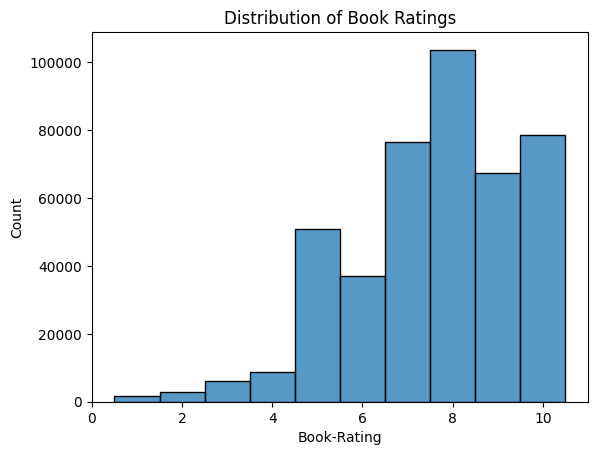

In [11]:
sns.histplot(data=df, x ='Book-Rating', discrete=True)
plt.title("Distribution of Book Ratings")
plt.show()

The average book rating is 7.6, or 8 if rounded to the nearest whole number to keep with the integer rating scale

In [12]:
df['Book-Rating'].mean()

7.601066246071331

Next, I examine the distribution of the average book rating

In [13]:
df.groupby(['ISBN'])['Book-Rating'].mean()


ISBN
 0330299891    6.0
 0375404120    3.0
 0586045007    NaN
 9022906116    7.0
 9032803328    NaN
              ... 
cn113107       NaN
ooo7156103     7.0
§423350229     NaN
´3499128624    8.0
Ô½crosoft      7.0
Name: Book-Rating, Length: 340556, dtype: float64

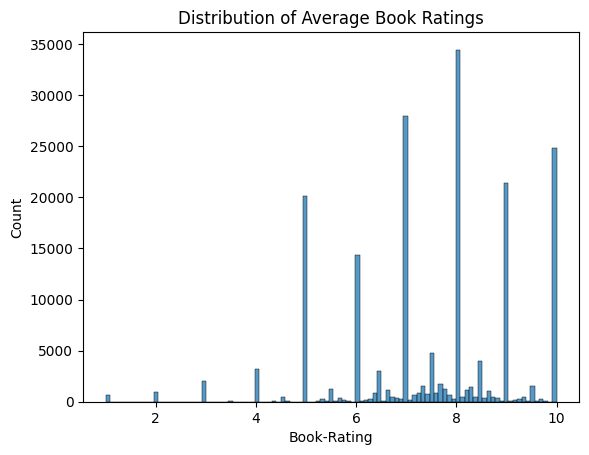

In [14]:
plt.figure()
sns.histplot(data=df.groupby('ISBN')['Book-Rating'].mean())
plt.title("Distribution of Average Book Ratings")
plt.show()

As we'll see below, many books have few ratings. This may be causing average book ratings to aggregate around whole number values, given that the rating scale is discrete from 1 to 10.

In [15]:
df.groupby(['ISBN'])['Book-Rating'].mean().describe()

count    185973.000000
mean          7.491347
std           1.731428
min           1.000000
25%           6.500000
50%           8.000000
75%           9.000000
max          10.000000
Name: Book-Rating, dtype: float64

Next, we look at the average rating per user.

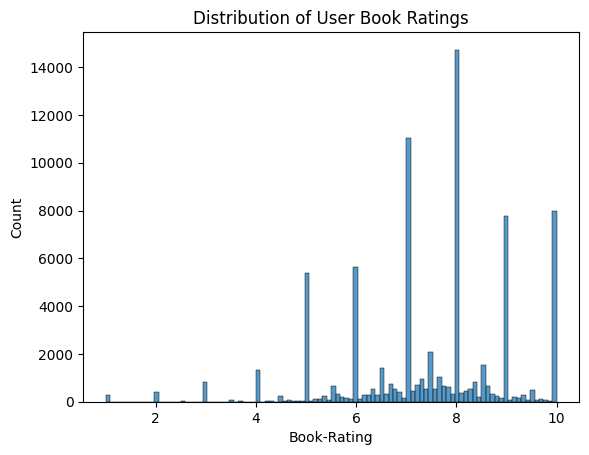

In [16]:

plt.figure()
sns.histplot(data=df.groupby('User-ID')['Book-Rating'].mean())
plt.title("Distribution of User Average Book Ratings")
plt.show()

The average rating is 7.5, suggesting users are lenient critics on average. Similar to books, many users have few ratings, potentially leading to the spikes at whole number values.

In [17]:
df.groupby(['User-ID'])['Book-Rating'].mean().describe()

count    77805.000000
mean         7.459926
std          1.630394
min          1.000000
25%          6.600000
50%          7.727273
75%          8.500000
max         10.000000
Name: Book-Rating, dtype: float64

Below we look at the number of ratings per book.

In [18]:
df.groupby('ISBN')['Book-Rating'].count()

ISBN
 0330299891    1
 0375404120    1
 0586045007    0
 9022906116    1
 9032803328    0
              ..
cn113107       0
ooo7156103     1
§423350229     0
´3499128624    1
Ô½crosoft      1
Name: Book-Rating, Length: 340556, dtype: int64

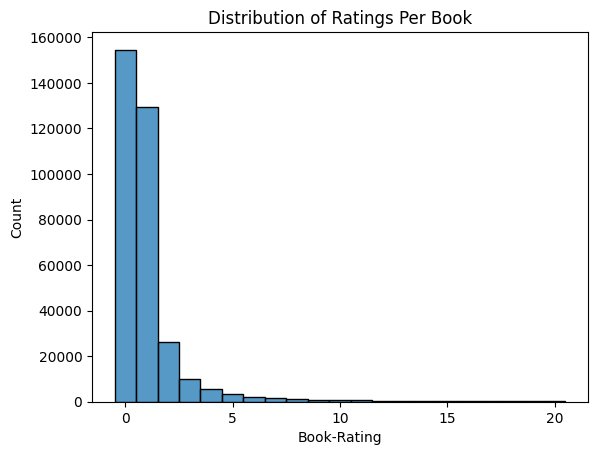

In [19]:
plt.figure()
sns.histplot(data=df.groupby('ISBN')['Book-Rating'].count(), discrete=True, binrange=(0,20))
plt.title("Distribution of Ratings Per Book")
plt.show()

In [20]:
df.groupby('ISBN')['Book-Rating'].count().describe()

count    340556.000000
mean          1.273421
std           5.182373
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max         707.000000
Name: Book-Rating, dtype: float64

As seen above, most books have very few ratings. For example, the 75th percentile is just 1 book rating, meaning only 25% of the books have more than one book rating.

In [21]:
df.groupby('User-ID')['Book-Rating'].count()

User-ID
2          0
7          0
8          7
9          1
10         1
          ..
278846     1
278849     1
278851    14
278852     1
278854     6
Name: Book-Rating, Length: 105283, dtype: int64

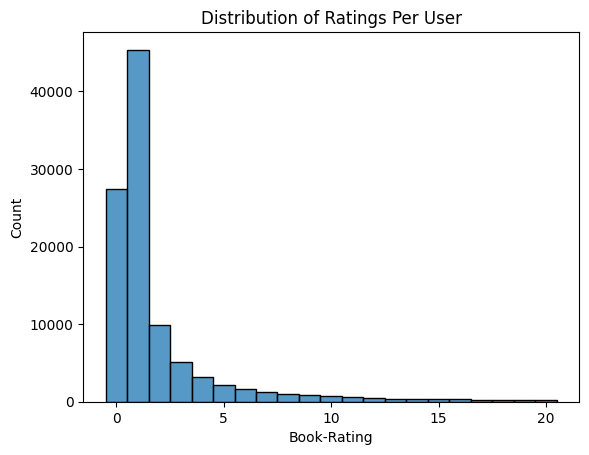

In [22]:
plt.figure()
sns.histplot(data=df.groupby('User-ID')['Book-Rating'].count(), discrete=True, binrange=(0,20))
plt.title("Distribution of Ratings Per User")
plt.show()

In [23]:
df.groupby('User-ID')['Book-Rating'].count().describe()

count    105283.000000
mean          4.119098
std          37.905533
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max        8524.000000
Name: Book-Rating, dtype: float64

There is a similar lack of data with user ratings. Here, the 75th percentile is 2, so only 25% of the users have more than 2 ratings.

This data sparsity presents an issue with creating recommendation algorithms as there are few user-item interactions that, known as the cold start problem. 

One approach to improve this issue is to filter out infrequently rated items. However, this leads to the long tail problem, which is when recommender systems avoid recommending items with few ratings and instead focus on the most popular items that have many interactions. This can result in a business problem, as users who are only recommended popular items may eventually exhaust the catalog (or get bored) and thus leave the service.

For this project, I will filter out infrequently rated items to improve recommendation accuracy and make for a more manageable dataset. However, an approach that could be used in the real world is to use a hybrid recommender model that combines recommendations from collaborative filtering approaches, which are based on the ratings matrix, with a content based model. The content based model could use book descriptions or can extract features from book cover images via AI to generate a similarity matrix for books based on these features. Then books that have few ratings but are similar to popular books based on these features could be included in recommendations to increase metrics like novelty, serendipity, diversity, etc.


In [24]:
df_filtered = df.copy()

Below I add a column that counts how many times a book has been rated.

In [25]:
df_filtered['Rating_Count'] = df_filtered.groupby('ISBN')['Book-Rating'].transform('count')

In [26]:
df_filtered.head()

,User-ID,ISBN,Book-Rating,Rating_Count
0,276725,034545104X,NaN,28
1,276726,0155061224,5.0,1
2,276727,0446520802,NaN,56
3,276729,052165615X,3.0,1
4,276729,0521795028,6.0,1


In [27]:
df_filtered['Rating_Count'].describe()

count    1.149780e+06
mean     1.950777e+01
std      5.447143e+01
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      1.300000e+01
max      7.070000e+02
Name: Rating_Count, dtype: float64

In [28]:
df_filtered['Rating_Count'].max()

707

As seen above, only 25% of the books have more than 13 ratings. For the purposes of this analysis, we will focus on books with at least ten ratings so that in an 80/20 train/test split, there can be enough observations to train on and a few observations to test on.

In [29]:
df_filtered = df_filtered[df_filtered['Rating_Count'] > 9].copy()
df_filtered.drop(['Rating_Count'], axis=1, inplace=True)

In [30]:
df_filtered.shape

(343969, 3)

This has reduced the rating entries from over 1M to around 350k.

In [31]:
df_filtered['ISBN'].nunique()

5645

In [32]:
df_filtered['User-ID'].nunique()

55154

There are now about 6,000 unique books and over 55,000 unique users.

In [33]:
df_filtered['User_Count'] = df_filtered.groupby('User-ID')['Book-Rating'].transform('count')

In [34]:
df_filtered.head()

,User-ID,ISBN,Book-Rating,User_Count
0,276725,034545104X,NaN,0
2,276727,0446520802,NaN,0
8,276744,038550120X,7.0,1
10,276746,0425115801,NaN,0
11,276746,0449006522,NaN,0


In [35]:
df_filtered['User_Count'].describe()

count    343969.000000
mean         44.428684
std         184.353193
min           0.000000
25%           3.000000
50%          12.000000
75%          36.000000
max        1967.000000
Name: User_Count, dtype: float64

There are still many users with few ratings. I will filter for users with at least five ratings to help ensure there is some user rating data for the collaborative filtering models to learn from. In a real world scenario, viewers with few ratings can be served recommendations of popular items until their preferences become more evident through interactions. Additionally, a hybrid model that considers features such as user age, gender, location, etc can be used to recommend users popular items of users that are determined to be similar based on those metrics.

In [36]:
df_filtered = df_filtered[df_filtered['User_Count'] > 4].copy()
df_filtered.drop(['User_Count'], axis=1, inplace=True)

In [37]:
df_filtered.shape

(234533, 3)

## SVD Algorithm

First, I will fit an SVD algorithm. As discussed in [prior projects](https://rpubs.com/stoybis/DATA612Project3), SVD is a matrix factorization technique that seeks to approximate the original ratings matrix as a product of three seperate matrics, U, Sigma, and V. 

While interpretability can get challenging as the size of the matrices grows, U can be though of as a “User to Concept” matrix, V as an “Item to Concept” matrix, and Sigma is a diagonal matrix where the singular values on the diagonal, all positive values sorted in descending order, explain the strength of each concept. These are known as latent factors (similar to principle components in PCA) and correspond to the main tuneable hyperparameter in SVD. 

This section references code from the recommenders package [deep dive on SVD](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/surprise_svd_deep_dive.ipynb)


In [38]:
#%pip install scikit-surprise 

In [39]:
import sys
import surprise

In [40]:
#%pip install recommenders

In [41]:
from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var,
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    get_top_k_items,
)
from recommenders.models.surprise.surprise_utils import (
    predict,
    compute_ranking_predictions,
)
from recommenders.utils.notebook_utils import store_metadata

Below I split the ratings data into train and test sets via an 80/20 split.

In [42]:
train, test = python_random_split(df_filtered, 0.80, seed=42)

In [43]:
train.head()

,User-ID,ISBN,Book-Rating
739636,178667,0767916069,NaN
325204,77383,0345318862,9.0
869994,210485,080411935X,8.0
34978,8253,0671755064,NaN
272370,63625,0062502182,10.0


In [44]:
from surprise import Reader, Dataset

The surprise library works with its own dataset objects rather than pandas data frames. Thus, I will convert the train and test set into the required surprise objects. 

In [45]:
reader = Reader(rating_scale=(1, 10))

data     = Dataset.load_from_df(train, reader)
trainset = data.build_full_trainset()


Next, I will train the SVD model on the training data. I will go with the default latent factors value of 200, though this parameter can be hypertuned.

In [46]:
svd = surprise.SVD(random_state=0, n_factors=200, n_epochs=30, verbose=True)

with Timer() as train_time:
    svd.fit(trainset)

print(f"Took {train_time.interval} seconds for training.")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Took 6.444793169999684 seconds for training.


Next, I adjust the test set to work with the surprise package.

In [47]:
test_for_surprise = (
    test
    .rename(columns={'User-ID':'userID', 'ISBN':'itemID', 'Book-Rating':'rating'})
)


Next, I check the test set for any missing values and drop them.

In [48]:
test_for_surprise.isna().sum()

userID        0
itemID        0
rating    28381
dtype: int64

In [49]:
test_for_surprise.dropna(subset=['rating'], inplace=True)

Next I predict the test set.

In [50]:
svd_predictions = predict(
    svd,
    test_for_surprise,
    usercol="userID",
    itemcol="itemID"
)

In [51]:
svd_predictions.head()

,userID,itemID,prediction
0,243075,059045370X,10
1,128835,0140053204,10
2,122793,0671868713,10
3,210485,0517577550,10
4,95903,0451190564,10


I then calculate the error metrics and record them.

In [52]:
svd_rmse = rmse(test_for_surprise, svd_predictions)
svd_mae = mae(test_for_surprise, svd_predictions)
svd_mse = svd_rmse**2

In [53]:
metrics_df = pd.DataFrame([{
    "rmse": svd_rmse,
    "mse":  svd_mae,
    "mae":  svd_mse
}])


metrics_df = metrics_df.rename(index={ (metrics_df.shape[0] - 1): "svd" })

In [54]:
metrics_df

,rmse,mse,mae
svd,2.769073,2.14396,7.667764


## Pyspark ALS

Next, I will try the ALS algorithm via Pyspark. As mentioned in [previous projects](https://rpubs.com/stoybis/DATA612Project5), ALS is a matrix factorization technique that, similar to ALS, seeks to approximate the original ratings matrix as the product of two smaller matrics, U and P. The optimal values are determined by holding one matrix (U) constant and finding values for the other matrix (P) that minimize the squared errors between the approximated matrix and the original matrix. Then, the matrix P is held constant at the optimal values and matrix U is optimized for values that minimize the squared errors. These matrices have rows corresponding to the users/items and columns corresponding to latent factors, which can be thought of as concepts (e.g. for movies a latent factor might represent a genre while another latent factor may capture the budget of a movie). Accordingly, these matrices capture how users and items rate on these latent factors and finding the dot product can approximate or predict how a user would rate an item. ALS works well with parallelization as the system computes the U and P matrices independently.

This section references code from the recommenders [deep dive on als](https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/als_deep_dive.ipynb).


In [55]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import FloatType, IntegerType, LongType

In [56]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

In [57]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

Below, I connect to a local spark session.

In [58]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .appName("ALSExample")
    .master("local[*]")        # run locally using all cores
    .getOrCreate()
)


25/07/20 01:08:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Next, I copy the train and test dataframes into spark 

In [59]:
spark_train = spark.createDataFrame(train.to_dict("records"))
spark_test  = spark.createDataFrame(test.to_dict("records"))


In [60]:
spark_train.printSchema()

root
 |-- Book-Rating: double (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- User-ID: long (nullable = true)



Next, I use the StringIndexer to create unique number IDs for books and users, as Pyspark requires numeric values for these fields.

In [61]:
indexer = StringIndexer(inputCol="ISBN", outputCol="Book-ID").setHandleInvalid("keep")
index_model = indexer.fit(spark_train)


In [62]:
spark_train = index_model.transform(spark_train).withColumn("Book-ID", col("Book-ID").cast("int"))
spark_test = index_model.transform(spark_test).withColumn("Book-ID", col("Book-ID").cast("int"))

In [63]:
spark_train.printSchema()

root
 |-- Book-Rating: double (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- User-ID: long (nullable = true)
 |-- Book-ID: integer (nullable = true)



In [64]:
spark_test.printSchema()

root
 |-- Book-Rating: double (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- User-ID: long (nullable = true)
 |-- Book-ID: integer (nullable = true)



In [65]:
from pyspark.sql.functions import col,isnan, when, count

I then check for missing values in the training and test set sets and drop missing values. Pyspark is not able to approximate the matrix if there are missing values.

In [66]:
spark_train.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_train.columns]).show()

In [67]:
spark_test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_test.columns]
   ).show()

+-----------+----+-------+-------+
|Book-Rating|ISBN|User-ID|Book-ID|
+-----------+----+-------+-------+
|      28381|   0|      0|      0|
+-----------+----+-------+-------+



In [68]:
#dropping null values from training set
spark_train = spark_train.na.drop(subset=["User-ID", "ISBN", "Book-Rating"])

In [69]:
spark_train.count()

73923

In [70]:
spark_train.select([count(when(isnan(c), c)).alias(c) for c in spark_train.columns]).show()

25/07/20 01:08:18 WARN TaskSetManager: Stage 12 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
+-----------+----+-------+-------+
|Book-Rating|ISBN|User-ID|Book-ID|
+-----------+----+-------+-------+
|          0|   0|      0|      0|
+-----------+----+-------+-------+



In [71]:
spark_test = spark_test.na.drop(subset=["User-ID", "ISBN", "Book-Rating"])

In [72]:
spark_test.select([count(when(isnan(c), c)).alias(c) for c in spark_test.columns]).show()

+-----------+----+-------+-------+
|Book-Rating|ISBN|User-ID|Book-ID|
+-----------+----+-------+-------+
|          0|   0|      0|      0|
+-----------+----+-------+-------+



In [73]:
spark_test.count()

18526

First, I will train the ALS algorithm with default values of 10 latent factors, 5 iterations for ALS, and a cost parameter of 0.1.

In [74]:
als = ALS(
    userCol="User-ID",
    itemCol="Book-ID",
    ratingCol='Book-Rating',
    coldStartStrategy="drop",
    implicitPrefs=False,
    nonnegative=True,
    rank = 10, seed = 100)

als.setMaxIter(5)
als.setRegParam(0.1)


ALS_3fa36a0d400e

In [75]:
als_model = als.fit(spark_train)

Next, I generate predictions for the test set.

In [76]:
predictions = als_model.transform(spark_test)

In [77]:
predictions.show()

+-----------+----------+-------+-------+----------+
|Book-Rating|      ISBN|User-ID|Book-ID|prediction|
+-----------+----------+-------+-------+----------+
|        8.0|0553099604| 178199|   4176|  6.662157|
|       10.0|0140280553|  23571|   1109|  8.135994|
|        4.0|0842329250| 161234|    476| 3.7380304|
|        8.0|0440195934| 245534|   3759| 6.9911695|
|        7.0|0156005891|  75149|   1022|  7.939999|
|       10.0|0312305060| 271000|     76|  6.829071|
|        9.0|0375727345| 132171|     20| 6.7211914|
|       10.0|0345384911|  78440|   2181| 7.4711566|
|        5.0|0451207521| 245534|    961| 7.2120132|
|        7.0|0373484410|  78440|    773|  6.857996|
|        9.0|0385335482|  15957|     42|    7.9587|
|        8.0|0425120279| 274549|   1447| 7.5680575|
|        8.0|068486424X| 268622|   3837| 3.6745436|
|        9.0|0446310786| 105536|     45|  8.967568|
|        6.0|0446519138| 178199|    715| 7.7676287|
|        5.0|0440224624| 245534|    290| 6.1577606|
|        9.0

In [78]:
predictions.select("prediction").summary().show()

+-------+-----------------+
|summary|       prediction|
+-------+-----------------+
|  count|            18506|
|   mean|  7.4400059735145|
| stddev|1.496952064713701|
|    min|              0.0|
|    25%|        6.5042057|
|    50%|         7.516905|
|    75%|          8.48151|
|    max|        12.176426|
+-------+-----------------+



Some of the predicted values are above 10, the max rating. There is no way to directly control for this in matrix factorization. Thus, I will cutoff any ratings that are above 10 to the max value of 10.

In [79]:
predictions = predictions.withColumn(
    'prediction_capped',
    when(col('prediction') > 10, 10).otherwise(col('prediction'))
)

In [80]:
predictions.show()

Next, I calculate error metrics.

In [81]:
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='Book-Rating', predictionCol='prediction_capped')
als_rmse = evaluator_rmse.evaluate(predictions)

evaluator_mse = RegressionEvaluator(metricName='mse', labelCol='Book-Rating', predictionCol='prediction_capped')
als_mse = evaluator_mse.evaluate(predictions)

evaluator_mae = RegressionEvaluator(metricName='mae', labelCol='Book-Rating', predictionCol='prediction_capped')
als_mae = evaluator_mae.evaluate(predictions)

In [82]:
metrics_df.loc[len(metrics_df)] = [als_rmse, als_mse, als_mae]

metrics_df = metrics_df.rename(index={ (metrics_df.shape[0] - 1): "als" })

In [83]:
metrics_df

,rmse,mse,mae
svd,2.769073,2.14396,7.667764
als,1.872723,3.50709,1.432630


Next, I will try tuning the hyper parameters to see if there is an improvement in performance.

In [84]:
als_tuned =ALS(userCol="User-ID",
    itemCol="Book-ID",
    ratingCol='Book-Rating',
    coldStartStrategy="drop",
    implicitPrefs=False,
    nonnegative=True)

param_grid = ParamGridBuilder()\
             .addGrid(als.rank, [20, 30, 40])\
             .addGrid(als.maxIter, [20])\
             .addGrid(als.regParam, [.05, .15])\
             .build()

In [85]:
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='Book-Rating', predictionCol='prediction')

cv = CrossValidator(
        estimator=als_tuned,
        estimatorParamMaps=param_grid,
        evaluator=evaluator_rmse,
        numFolds=3)

In [86]:
als_tuned_model = cv.fit(spark_train)

25/07/20 01:08:38 WARN TaskSetManager: Stage 272 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
25/07/20 01:08:47 WARN TaskSetManager: Stage 383 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
25/07/20 01:08:47 WARN TaskSetManager: Stage 384 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
25/07/20 01:08:54 WARN TaskSetManager: Stage 437 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
25/07/20 01:08:55 WARN TaskSetManager: Stage 495 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
25/07/20 01:08:55 WARN TaskSetManager: Stage 496 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.
25/07/20 01:09:01 WARN TaskSetManager: Stage 549 contains a task of very large size (2597 KiB). The maximum recommended task size is 1000 KiB.

In [87]:
final_tuned_model = als_tuned_model.bestModel


In [88]:
print('rank: ', final_tuned_model.rank)
print('MaxIter: ', final_tuned_model._java_obj.parent().getMaxIter())
print('RegParam: ', final_tuned_model._java_obj.parent().getRegParam())

rank:  10
MaxIter:  10
RegParam:  0.1


The hyperparameters of the best performing model were similar to the default values tried earlier.

Below I generate predictions and track the performance. Similar to before, predictions above a value of 10 will be capped at 10.

In [89]:
predictions_tuned = als_tuned_model.bestModel.transform(spark_test)

In [90]:
predictions_tuned.show()

+-----------+----------+-------+-------+----------+
|Book-Rating|      ISBN|User-ID|Book-ID|prediction|
+-----------+----------+-------+-------+----------+
|        8.0|0553099604| 178199|   4176|  6.569359|
|       10.0|0140280553|  23571|   1109|  9.458058|
|        4.0|0842329250| 161234|    476|  4.145751|
|        8.0|0440195934| 245534|   3759|  6.170793|
|        7.0|0156005891|  75149|   1022|  5.432569|
|       10.0|0312305060| 271000|     76|  5.924842|
|        9.0|0375727345| 132171|     20| 6.8241224|
|       10.0|0345384911|  78440|   2181| 6.5039816|
|        5.0|0451207521| 245534|    961| 7.3326364|
|        7.0|0373484410|  78440|    773| 7.2826796|
|        9.0|0385335482|  15957|     42|  5.880274|
|        8.0|0425120279| 274549|   1447|  7.971946|
|        8.0|068486424X| 268622|   3837|  7.915738|
|        9.0|0446310786| 105536|     45|  9.980507|
|        6.0|0446519138| 178199|    715|  9.456108|
|        5.0|0440224624| 245534|    290|  5.401809|
|        9.0

In [91]:
predictions_tuned.select("prediction") \
           .summary() \
           .show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|             18506|
|   mean| 7.374750154908381|
| stddev|1.4673478192089586|
|    min|         0.5074313|
|    25%|         6.4415355|
|    50%|         7.4560103|
|    75%|          8.385116|
|    max|         12.083034|
+-------+------------------+



In [92]:
predictions_tuned = predictions_tuned.withColumn(
    'prediction_capped',
    when(col('prediction') > 10, 10).otherwise(col('prediction'))
)

In [93]:
evaluator_rmse = RegressionEvaluator(metricName='rmse', labelCol='Book-Rating', predictionCol='prediction_capped')
rmse_tuned = evaluator_rmse.evaluate(predictions_tuned)

mse_tuned = evaluator_mse.evaluate(predictions_tuned)

mae_tuned = evaluator_mae.evaluate(predictions_tuned)


In [94]:
metrics_df.loc[len(metrics_df)] = [rmse_tuned, mse_tuned, mae_tuned]
metrics_df = metrics_df.rename(index={ (metrics_df.shape[0] - 1): "pyspark_als_tuned" })

In [95]:
metrics_df

,rmse,mse,mae
svd,2.769073,2.143960,7.667764
als,1.872723,3.507090,1.432630
pyspark_als_tuned,1.855174,3.441669,1.427508


In [96]:
spark.stop()

In [97]:
metrics_df

,rmse,mse,mae
svd,2.769073,2.143960,7.667764
als,1.872723,3.507090,1.432630
pyspark_als_tuned,1.855174,3.441669,1.427508


## Global baseline model

Next, I generate a baseline model that simply predicts the global average for every prediction. This is used as a benchmark for comparison and evaluation purposes of more complex models.

In [98]:
global_avg = round(train['Book-Rating'].mean())

In [99]:
test.head()

,User-ID,ISBN,Book-Rating
580347,139827,042514545X,NaN
350901,84024,0440224675,NaN
1055057,251844,0345369947,NaN
1014480,243075,059045370X,5.0
37553,8936,0425158616,NaN


In [100]:
baseline_rmse = np.sqrt((((test['Book-Rating'] - global_avg)**2).sum())/(test['Book-Rating'].count()))


In [101]:
baseline_mae = abs(test['Book-Rating'] - global_avg).sum()/(test['Book-Rating'].count())


In [102]:
baseline_mse = (((test['Book-Rating'] - global_avg)**2).sum())/(test['Book-Rating'].count())


In [103]:
metrics_df.loc[len(metrics_df)] = [baseline_rmse, baseline_mse, baseline_mae]
metrics_df = metrics_df.rename(index={ (metrics_df.shape[0] - 1): "global_baseline" })

## Conclusion

In [104]:
metrics_df

,rmse,mse,mae
svd,2.769073,2.143960,7.667764
als,1.872723,3.507090,1.432630
pyspark_als_tuned,1.855174,3.441669,1.427508
global_baseline,1.758387,3.091925,1.336662


As seen in the metrics table above, all models failed to outperform the global baseline model, though the ALS model with hyperparameter tuning came the closest. While this dataset initially seemed to be a large dataset, it was found that the dataset was sparse as many items and users had few ratings (discussed in the exploratory analysis section). This likely posed a headwind for the matrix factorization algorithms used above, as highly sparse data makes it harder for these algorithms to accurately approximate user-item interactions. Lastly, ratings were not normalized for user and item biases in the interest of time. Normalizing may lead to performance improvements by removing user and item bias. I have found that the pipeline for normalizing data is easier in R than in Python.

Content based filtering may have been useful in this scenario. For example, pulling book descriptions to create tf-idf measures and use those to create a similarity matrix could have helped in scenarios where a user or item only has a few ratings. Because other similar items are identified based on their descriptions, users that only rated a low amount of items would still be able to get served recommendations based on the descriptions of those books and their similarity to others. Unfortunately,  I ran into an API request limit when trying to pull descriptions for the books in the training and test sets.

Another content based approach would have been to use Azure's computer vision to generate captions for book cover images. These captions could then also be analyzed for tf-idf in order to measure similarity among books. However, it seemed like this approach would be costly given the size of the original dataset and the cost to make calls to Azure's Computer Vision API.
